## Импорты

In [2]:
from IPython.display import clear_output
%pip install skimpy
%pip install --user linear-tree
%pip install --upgrade pip
%pip install --user --upgrade Pillow
%pip install --upgrade matplotlib
%pip install ydata_profiling
clear_output()

In [1]:
import pandas as pd
import numpy as np
import math

from ydata_profiling import ProfileReport
import skimpy
import sys
import time

from IPython.display import Markdown
import nbformat

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from catboost import Pool, CatBoostRegressor, cv
from lineartree import LinearTreeRegressor, LinearForestRegressor
from lineartree import LinearBoostRegressor

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
# plt.style.use('default')
plt.style.use('dark_background') # я работаю в темной теме, поэтому использую эту настройку.
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

s = 42

## Обзор данных

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
skimpy.skim(train)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 440236 │ │ string      │ 11    │                                                          │
│ │ Number of columns │ 15     │ │ int32       │ 2     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 2     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name   ┃ NA    ┃ NA %                   ┃ mean   ┃ sd     ┃ p0   ┃ p25   ┃ p75   ┃ p100    ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩  │
│ │ year          │     0 │                      0 │   2000 │      4 │ 2000 │  2000 │  2000 │    2000 │    ▁▃█ │  │
│ │ condition     │  9405 │      2.136354137326343 │    3.4 │   0.95 │    1 │   2.7 │   4.2 │       5 │  ▄▄▅█▅ │  │
│ │ odometer      │    69 │   0.015673411533813682 │  68000 │  54000 │    1 │ 28000 │ 99000 │ 1000000 │   █    │  │
│ │ sellingprice  │     0 │                      0 │  14000 │   9800 │    1 │  6900 │ 18000 │  230000 │   █    │  │
│ └───────────────┴───────┴────────────────────────┴────────┴────────┴──────┴───────┴───────┴─────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name          ┃ NA        ┃ NA %                         ┃ words per row        ┃ total words       ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩  │
│ │ make                 │      8043 │           1.8269746227023687 │                 0.99 │            433689 │  │
│ │ model                │      8123 │            1.845146694045921 │                 0.99 │            433689 │  │
│ │ trim                 │      8337 │           1.8937569848899227 │                 0.99 │            433689 │  │
│ │ body                 │     10393 │           2.3607792184192116 │                 0.99 │            433689 │  │
│ │ transmission         │     51461 │           11.689412042631679 │                 0.99 │            433689 │  │
│ │ vin                  │         0 │                            0 │                 0.99 │            433689 │  │
│ │ state                │         0 │                            0 │                 0.99 │            433689 │  │
│ │ color                │       586 │           0.1331104225915191 │                 0.99 │            433689 │  │
│ │ interior             │       586 │           0.1331104225915191 │                 0.99 │            433689 │  │
│ │ seller               │         0 │                            0 │                 0.99 │            433689 │  │
│ │ saledate             │         0 │                            0 │                 0.99 │            433689 │  │
│ └──────────────────────┴───────────┴──────────────────────────────┴──────────────────────┴───────────────────┘  │
╰────────────────────────────────────────────────────── 

In [4]:
skimpy.skim(test)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 110058 │ │ string      │ 11    │                                                          │
│ │ Number of columns │ 14     │ │ float64     │ 2     │                                                          │
│ └───────────────────┴────────┘ │ int32       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name  ┃ NA    ┃ NA %                   ┃ mean   ┃ sd     ┃ p0    ┃ p25   ┃ p75   ┃ p100    ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩  │
│ │ year         │     0 │                      0 │   2000 │      4 │  2000 │  2000 │  2000 │    2000 │    ▁▃█ │  │
│ │ condition    │  2379 │      2.161587526576896 │    3.4 │   0.95 │     1 │   2.7 │   4.2 │       5 │  ▄▅▆█▅ │  │
│ │ odometer     │    19 │   0.017263624634283742 │  68000 │  54000 │     1 │ 28000 │ 99000 │ 1000000 │   █    │  │
│ └──────────────┴───────┴────────────────────────┴────────┴────────┴───────┴───────┴───────┴─────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name         ┃ NA        ┃ NA %                          ┃ words per row        ┃ total words       ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩  │
│ │ make                │      2061 │            1.8726489669083575 │                 0.98 │            108365 │  │
│ │ model               │      2079 │            1.8890039797197842 │                 0.98 │            108365 │  │
│ │ trim                │      2114 │            1.9208053935197804 │                 0.98 │            108365 │  │
│ │ body                │      2594 │             2.356939068491159 │                 0.98 │            108365 │  │
│ │ transmission        │     13011 │            11.821948427192934 │                 0.98 │            108365 │  │
│ │ vin                 │         0 │                             0 │                 0.98 │            108365 │  │
│ │ state               │         0 │                             0 │                 0.98 │            108365 │  │
│ │ color               │       158 │           0.14356066801141215 │                 0.98 │            108365 │  │
│ │ interior            │       158 │           0.14356066801141215 │                 0.98 │            108365 │  │
│ │ seller              │         0 │                             0 │                 0.98 │            108365 │  │
│ │ saledate            │         0 │                             0 │                 0.98 │            108365 │  │
│ └─────────────────────┴───────────┴───────────────────────────────┴──────────────────────┴───────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [5]:
pd.to_datetime(train['saledate'], utc=True).sort_values()

378740   2014-01-01 01:15:00+00:00
352167   2014-01-01 01:15:00+00:00
259284   2014-01-01 01:15:00+00:00
49379    2014-01-01 01:15:00+00:00
38837    2014-01-01 01:15:00+00:00
                    ...           
270468   2015-07-13 23:30:00+00:00
338695   2015-07-13 23:30:00+00:00
188305   2015-07-13 23:30:00+00:00
106619   2015-07-13 23:30:00+00:00
391308   2015-07-20 19:30:00+00:00
Name: saledate, Length: 440236, dtype: datetime64[ns, UTC]

In [6]:
pd.to_datetime(test['saledate'], utc=True).sort_values()

21328    2014-01-01 01:15:00+00:00
14376    2014-01-01 01:15:00+00:00
11145    2014-01-01 01:15:00+00:00
1920     2014-01-01 01:15:00+00:00
107192   2014-01-01 01:15:00+00:00
                    ...           
101412   2015-07-09 02:00:00+00:00
75309    2015-07-09 10:15:00+00:00
15633    2015-07-09 23:00:00+00:00
47922    2015-07-13 23:30:00+00:00
19       2015-07-13 23:30:00+00:00
Name: saledate, Length: 110058, dtype: datetime64[ns, UTC]

In [7]:
train = train.drop('saledate', axis=1)
test = test.drop('saledate', axis=1)

In [8]:
ProfileReport(train)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
ProfileReport(test)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
dtypes: float64(2), int64(2), object(10)
memory usage: 47.0+ MB


In [11]:
train.columns

Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'vin', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'sellingprice'],
      dtype='object')

In [12]:
train['make'].unique().shape[0]

93

In [13]:
train['make'].value_counts().head(10)

make
Ford         73708
Chevrolet    47492
Nissan       42811
Toyota       31630
Dodge        24103
Honda        21485
Hyundai      17170
BMW          16198
Kia          14321
Chrysler     13623
Name: count, dtype: int64

In [14]:
target = 'sellingprice'
cat_cols = ['make', 'model', 'trim', 'body', 'transmission','state','color','interior','seller']
num_cols = list(train.columns.drop(cat_cols+['vin']+[target]))
train[cat_cols] = train[cat_cols].fillna('unknown')
train[num_cols] = train[num_cols].fillna(train[num_cols].median())

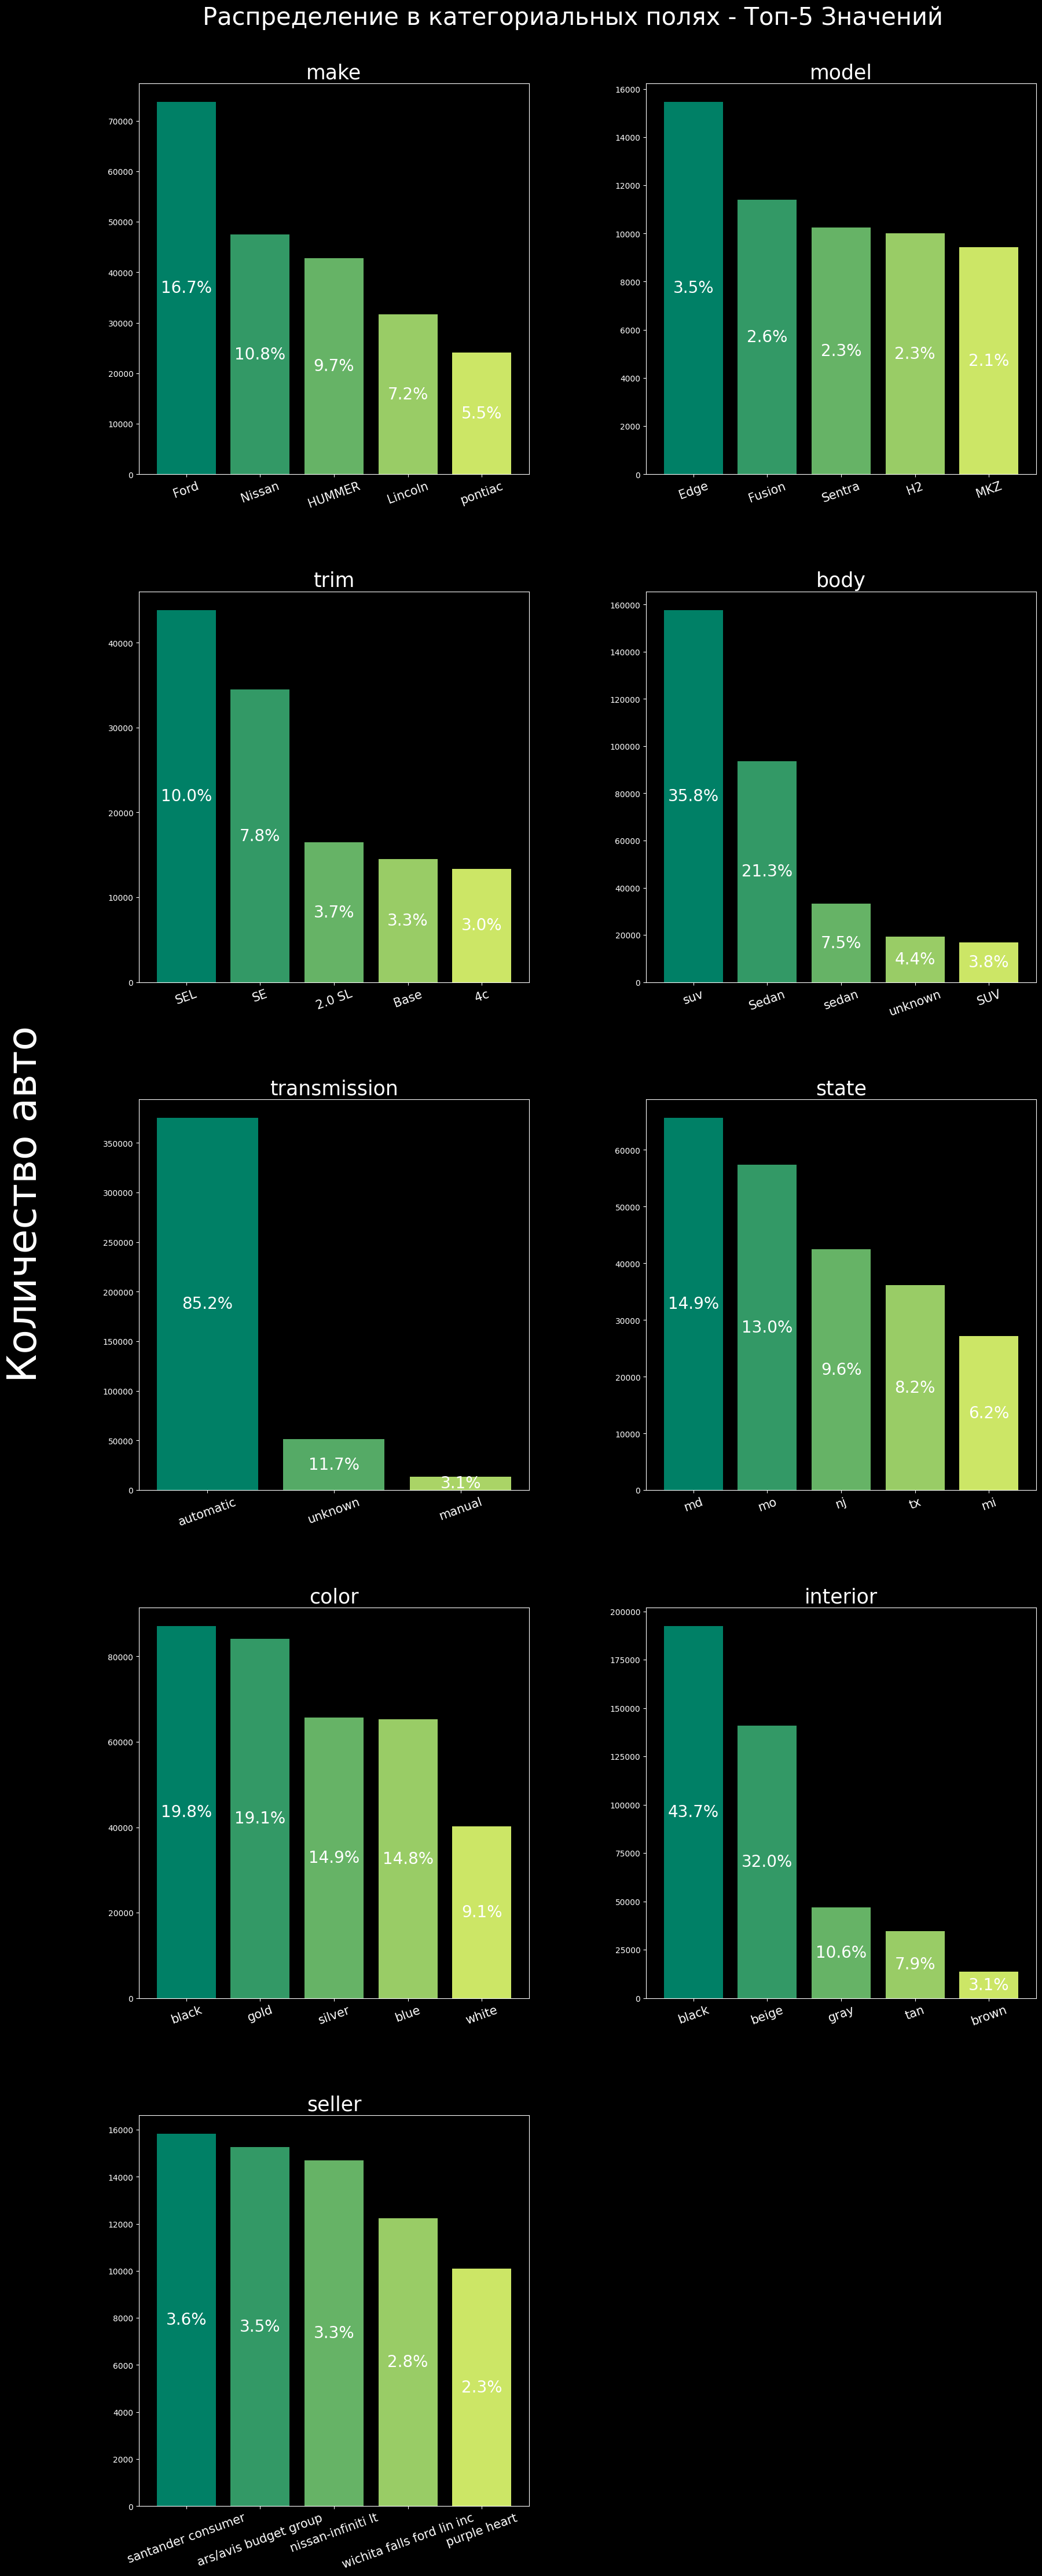

In [15]:

df = train.copy()

palette = plt.cm.summer
fig = plt.figure()
plot_num = 1
fig.text(0.01, 0.75, 'Количество авто', va='center', rotation='vertical', size=50) 

# цикл по столбцам
for col in cat_cols:
    ax = fig.add_subplot(len(cat_cols), 2, plot_num)
    value_counts = df[col].value_counts().head(5)  # Получаем топ-5 значений
    ax.bar(value_counts.index.map(str), value_counts.values)  # Отображаем только топ-5 баров
    ax.set_title(col,size=25)
 #   ax.set_ylabel('Количество пользователей',size=18) # если нужно будет добавить подпись оси Y на каждый график
    plot_num += 1
    
    x_tick_locations = np.arange(len(df[col].map(str).unique()))
    ax.set_xticks(x_tick_locations)
    ax.set_xticklabels(df[col].map(str).unique(), rotation=20,fontsize=15)
        
    # counts = df[col].value_counts()
    x = np.arange(len(value_counts))
    
    # цикл по барам
    for i, count in enumerate(value_counts):
        
        # вычисляем процентное соотношение для каждого бара
        percent = count / df[col].count() * 100
        
        # добавляем подпись с процентами
        ax.annotate('{:.1f}%'.format(percent), xy=(x[i], count/2), 
                    xytext=(0, -10), textcoords='offset points',
                    ha='center', va='bottom', fontsize=20)
        
        # добавляем цвет
        color = palette(i / len(value_counts))
        ax.bar(x[i], count, color=color)

               
fig.set_size_inches(20, 90)
fig.suptitle('Распределение в категориальных полях - Топ-5 Значений', fontsize=30)
fig.subplots_adjust(top=0.965,hspace=0.3,wspace=0.3)
plt.show()

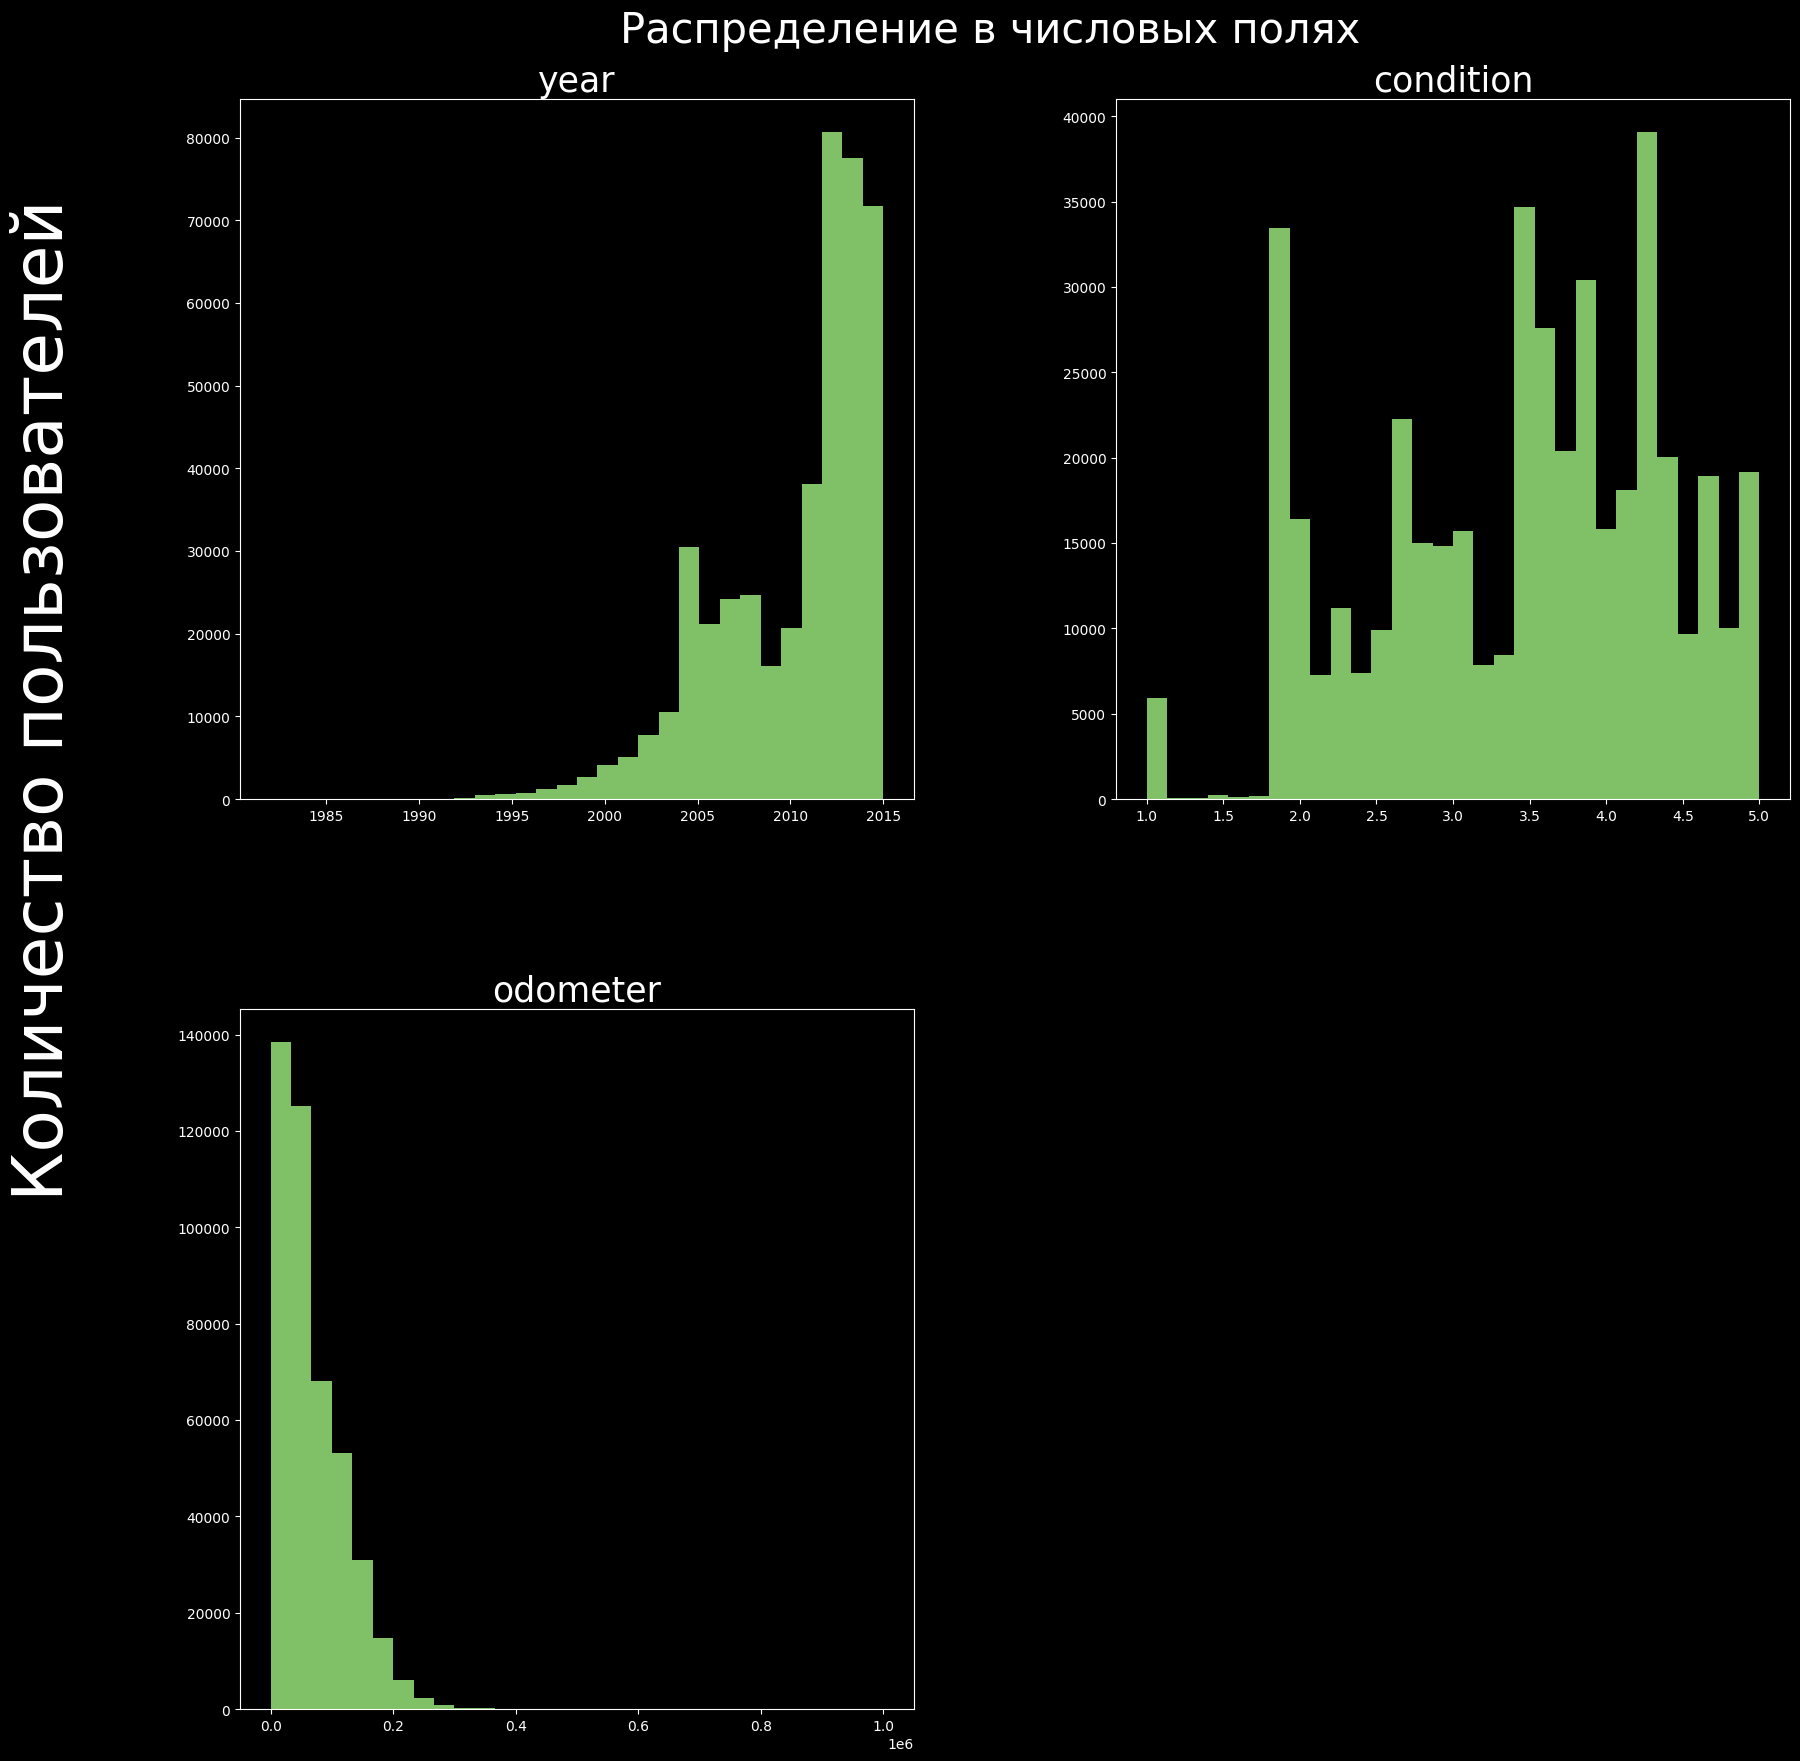

In [16]:
fig = plt.figure()
plot_num = 1
fig.text(0.01, 0.75, 'Количество пользователей', va='center', rotation='vertical', size=50) 

# цикл по столбцам
for col in num_cols:
    
    ax = fig.add_subplot(len(num_cols), 2, plot_num)
    ax.hist(df[col], bins=30, color=plt.cm.summer(0.5)) 
    ax.set_title(col,size=25)
#   ax.set_ylabel('Количество пользователей',size=18) # если нужно будет добавить подпись оси Y на каждый график
    plot_num += 1

fig.set_size_inches(20, 30)
fig.suptitle('Распределение в числовых полях', fontsize=30)
fig.subplots_adjust(top=0.95,hspace=0.3,wspace=0.3)
plt.show()

In [17]:
def groupby_left(df,column,agg):
    """Функция берёт на вход датафрейм, название столбца и название функций.
    По ним будет производиться группировка по столбцу с стоимостью авто."""
    return df.groupby(column)['sellingprice'].agg(agg)

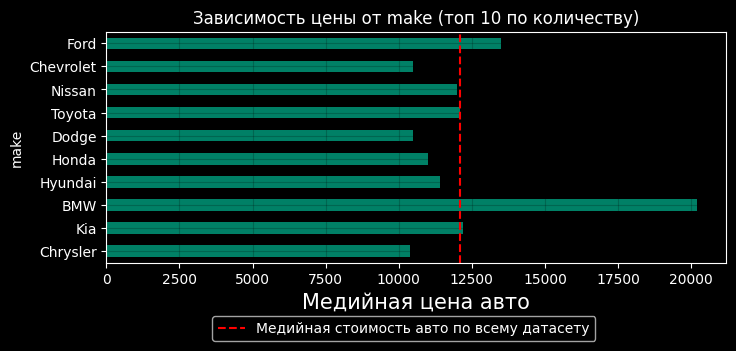

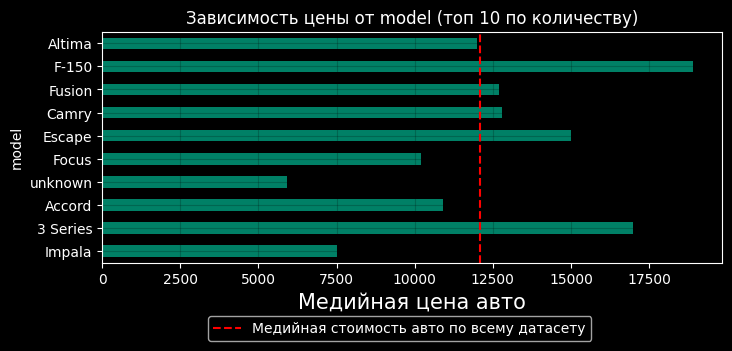

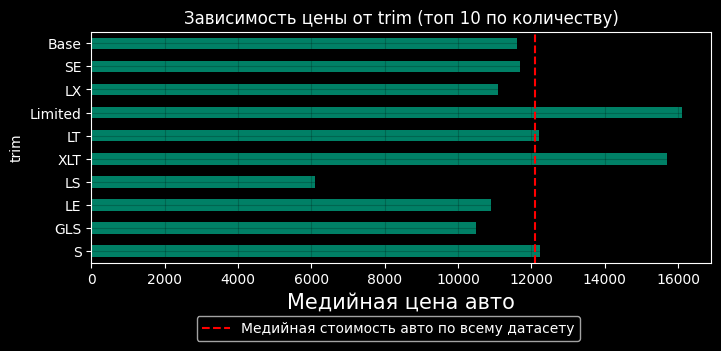

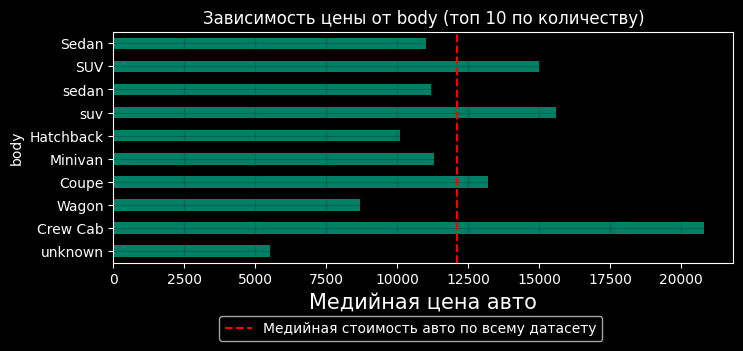

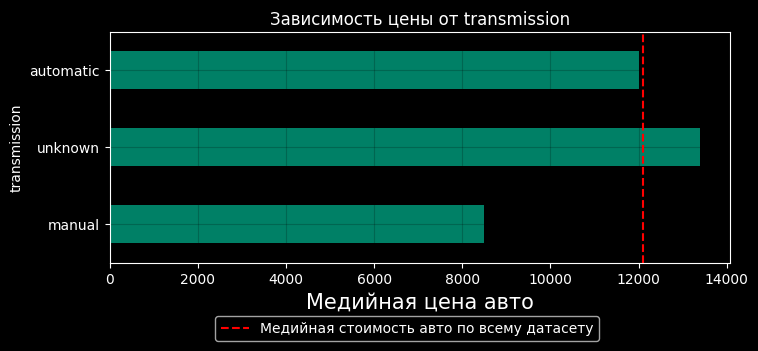

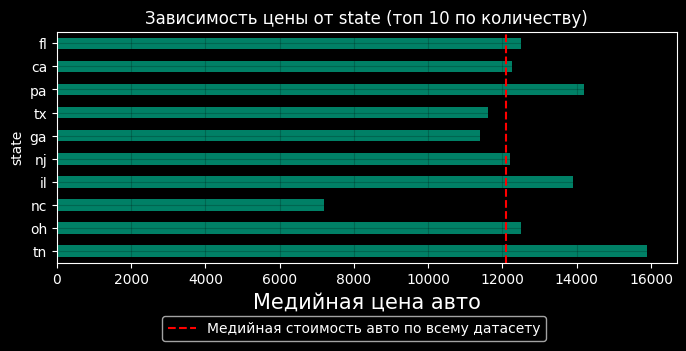

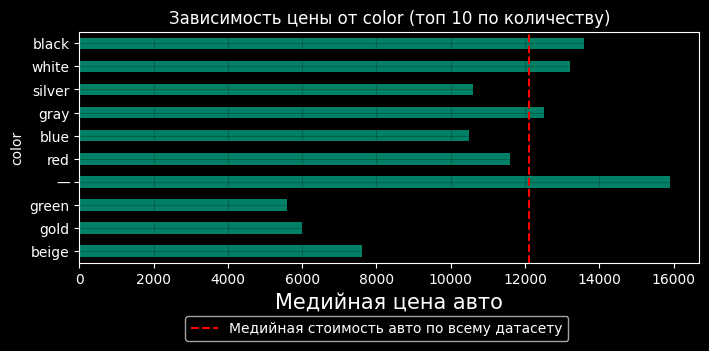

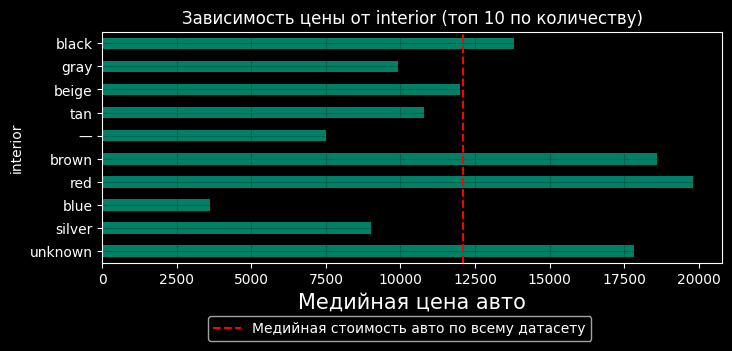

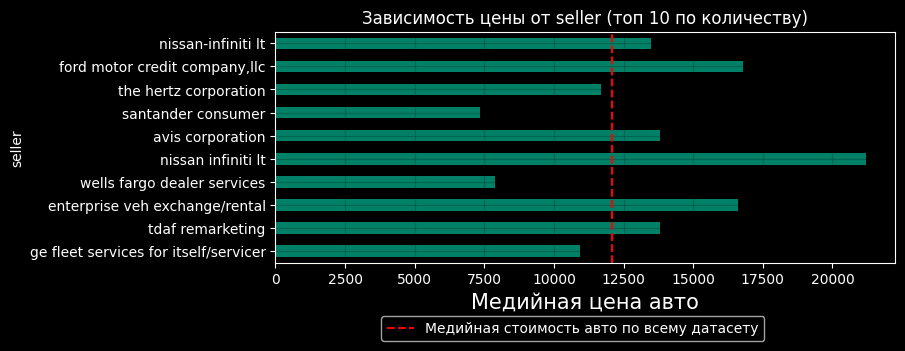

In [18]:
features = cat_cols + num_cols
cmap = plt.cm.summer(0.5)
agg = 'median'

for column in cat_cols:

    top = (groupby_left(df,column,['count',agg])
                       .sort_values(by = 'count', ascending = False)
                       .head(10).sort_values('count')[agg])
    plot = top.plot(kind='barh',cmap=plt.cm.summer, figsize=(8,3),rot=0,grid=True,legend=False)

    if df[column].unique().shape[0] >= 10:
        plt.title(f'Зависимость цены от {column} (топ 10 по количеству)')
    else:
        plt.title(f'Зависимость цены от {column}')

    plt.xlabel('Медийная цена авто',size = 15)
    plt.axvline(x=round(df[target].agg(agg),5),
                color='red', linestyle='--', 
                label='Средняя стоимость авто')
    
    means = round(groupby_left(df,column,[agg]).loc[:, agg],2)
    
    # for i, bar in enumerate(plot.get_children()[:len(means)]):
    #     bar.set_color(cmap(i / len(means)))
    
    # for x, y, label in zip(range(len(means)), means, means):
    #     plt.text(x, y+0.02, label, ha='center', va='bottom')
    plt
    plt.grid(color='black',alpha=0.2)
    plt.legend(['Медийная стоимость авто по всему датасету'],fontsize='medium',bbox_to_anchor=(0.8, -0.2))
    plt.show()

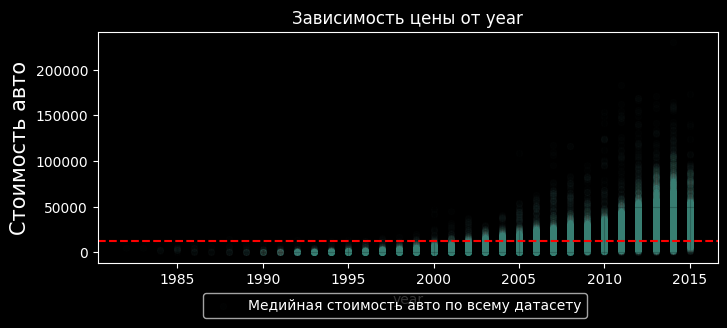

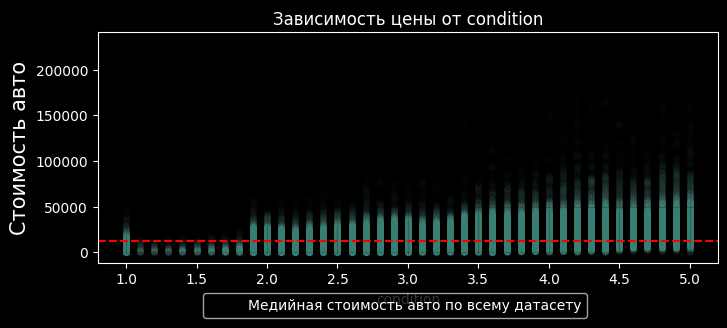

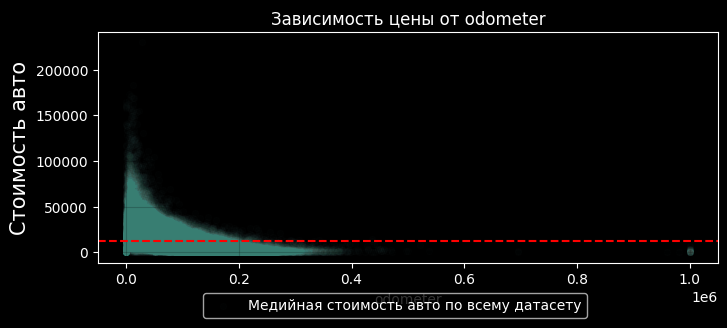

In [19]:
for column in num_cols:

    plot = df.plot(x=column,y=target,kind='scatter', 
                    cmap=plt.cm.summer, 
                    figsize=(8,3), rot=0, 
                    grid=True, legend=False, 
                    alpha = 0.01)

    plt.title(f'Зависимость цены от {column}')

    plt.ylabel('Стоимость авто',size = 15) 
    plt.axhline(y=round(df[target].agg(agg),5),
                color='red', linestyle='--', 
                label='Медийная стоимость авто')

    plt
    plt.grid(color='black',alpha=0.2)
    plt.legend(['Медийная стоимость авто по всему датасету'],fontsize='medium',bbox_to_anchor=(0.8, -0.1))
    plt.show()

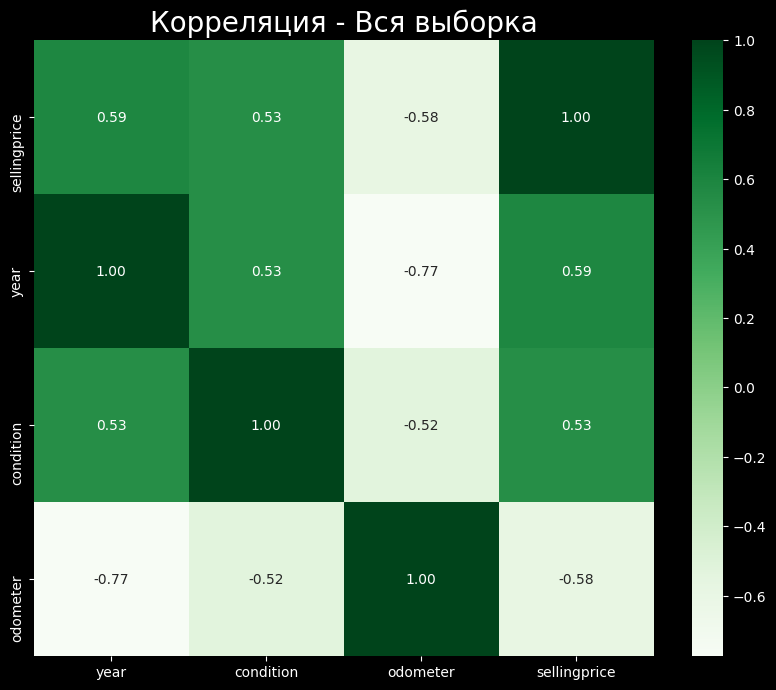

In [20]:
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols+[target]].corr().sort_values(by=target, ascending=False),
            annot=True, 
            cmap="Greens", 
            fmt='.2f')
plt.title('Корреляция - Вся выборка',size=20)
plt.show()

In [21]:
for i in train[cat_cols]:

    value_counts = df[i].value_counts()

    rare_values = value_counts[value_counts < 15].index.tolist()

    train[i] = train[i].apply(lambda x: 'rare' if x in rare_values else x)

In [22]:
for i in train[cat_cols]: 
    display(train[i].value_counts().tail(10))

make
volkswagen    20
landrover     19
vw            18
Tesla         17
Ferrari       17
porsche       17
hyundai       17
Plymouth      16
Geo           16
oldsmobile    15
Name: count, dtype: int64

model
Jetta Hybrid     16
Transit Van      16
LHS              15
GS 400           15
S8               15
Voyager          15
Transit Wagon    15
V8 Vantage       15
mkt              15
Sephia           15
Name: count, dtype: int64

trim
Sport Edition                   15
fwd v6                          15
XLT Value                       15
NBX                             15
Special                         15
Carrera S (Midyear Redesign)    15
ML63 AMG                        15
S400 Hybrid                     15
ML350 BlueTEC 4MATIC            15
Track Edition                   15
Name: count, dtype: int64

body
Promaster Cargo Van    38
Q60 Convertible        31
Xtracab                29
Q60 Coupe              26
CTS-V Coupe            24
TSX Sport Wagon        24
cts coupe              22
koup                   21
club cab               18
elantra coupe          18
Name: count, dtype: int64

transmission
automatic    375061
unknown       51461
manual        13714
Name: count, dtype: int64

state
ms    1468
ut    1451
qc    1000
hi     992
or     928
ab     729
nm     130
ok      60
ns      52
al      19
Name: count, dtype: int64

color
brown        5320
orange       1629
purple       1250
off-white    1143
yellow        979
unknown       586
charcoal      389
turquoise     183
pink           32
rare           14
Name: count, dtype: int64

interior
silver       844
unknown      586
off-white    373
purple       276
gold         256
white        215
green        198
burgundy     155
orange       109
yellow        16
Name: count, dtype: int64

seller
north penn imports inc                          15
lake trust credit union                         15
primeritus remarketing/midwest auto mart llc    15
findlay volkswagen                              15
kull auto sales inc                             15
victory mitsubishi                              15
land rover minneapolis                          15
capital ford inc                                15
c&a auto ny corp                                15
premier remarketing llc                         15
Name: count, dtype: int64

In [23]:
df = train.copy().drop(['vin'], axis=1)

X = df.drop([target], axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = s)

print('Размер признаков в обучабщей выборке:',X_train.shape[0])
print('Размер признаков в тестовой выборке:',X_test.shape[0])
print('Размер таргета в обучабщей выборке:',y_train.shape[0])
print('Размер таргета в тестовой выборке:',y_test.shape[0])

Размер признаков в обучабщей выборке: 352188
Размер признаков в тестовой выборке: 88048
Размер таргета в обучабщей выборке: 352188
Размер таргета в тестовой выборке: 88048


In [24]:
metric = 'MAPE'

ohe = ColumnTransformer([('encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                               ('scaler', MinMaxScaler(), num_cols)],
                                remainder='passthrough')

oe = ColumnTransformer([('encoder', OrdinalEncoder(handle_unknown='error'), cat_cols),
                              ('scaler', MinMaxScaler(), num_cols)],
                               remainder='passthrough')

pd.options.display.float_format = '{: .3f}'.format

results = pd.DataFrame(columns=[metric,'Время обучения','Время предсказания'])
results

Empty DataFrame
Columns: [MAPE, Время обучения, Время предсказания]
Index: []

In [25]:
def metrics(df,model,score,fit,pred):
    f'''Функция берёт на вход датафрейм, название модели, показаетль {metric} (по CV),
    время обучения и время предсказания. Добавляет строку с показателями модели.'''
    
    df.loc[model,'Время обучения'] = fit
    df.loc[model,'Время предсказания'] = pred
    df.loc[model, metric] = score
    
    return df

In [26]:
def grid_fit(model,params, cv=4, X_train=X_train, y_train=y_train):
    f"""Фукция берет на вход модель, и гиперпараметры для GridSearchCV.
    Проводит обучение с выявлением лучших гиперпараметров по метрике {metric}.
    Возвращает обученную модель, лучший {metric}, время обучения и предсказания модели."""
    
    grid = GridSearchCV(model, 
                        param_grid=params, 
                        scoring='neg_mean_absolute_percentage_error',
                        cv = cv)
        
    grid.fit(X_train,y_train)
    
    i = (list(grid.cv_results_['rank_test_score'])).index(1)
    score = grid.cv_results_['mean_test_score'][i]*-1
    time_fit = grid.cv_results_['mean_fit_time'][i]
    time_pred = grid.cv_results_['mean_score_time'][i]
    
    print('Лучшие параметры модели:', grid.best_params_)
    print(metric, score)
    print('Время обучения модели:', time_fit)
    print('Время предсказания модели:', time_pred)
    
    return grid, score, time_fit, time_pred

In [27]:
def pred(model):
    """Функция берёт на вход модель, обучает её на обучающей выборке,
    делает предсказания и проверяет MAPE на тестовой выборке.
    На выход идёт MAPE, время обучения и предсказания."""
    
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    time_fit = end - start

    start = time.time()
    preds = model.predict(X_test)
    end = time.time()
    pred_proba = model.predict_proba(X_test)
    pred_proba = pred_proba[:, 1]
    MAPE = mean_absolute_percentage_error(y_test, pred_proba)
    time_pred = end - start
    
    print('Время обучения модели:', time_fit)
    print('Время предсказания модели:', time_pred)
    print('MAPE', MAPE)
    
    return preds, MAPE, time_fit, time_pred

In [28]:
%%time

model = LinearRegression()

pipe = Pipeline([('ohe', ohe),
                 ('lr', model)])

params = {
        'lr__fit_intercept': [False],
        'lr__copy_X': [True]
          }

grid, score, ft, pt = grid_fit(pipe,params,cv=4)

metrics(results, f'{model}'[:-2], score, ft, pt)

Лучшие параметры модели: {'lr__copy_X': True, 'lr__fit_intercept': False}
MAPE 0.5514358175910175
Время обучения модели: 10.920968413352966
Время предсказания модели: 0.4507955312728882
CPU times: total: 42.9 s
Wall time: 44 s


MAPE Время обучения Время предсказания
LinearRegression  0.551         10.921              0.451

In [29]:
%%time

model = CatBoostRegressor(loss_function='RMSE',
                          random_state=s,
                          early_stopping_rounds=100,
                          verbose=1000)

pipe = Pipeline([('oe', oe),
                 ('cbr', model)])

params = {
        'cbr__learning_rate':[0.8],
        'cbr__depth':[7,8]
          }

grid, score, ft, pt = grid_fit(pipe,params,cv=4)

metrics(results, 'CatBoostRegressor_oe', score, ft, pt)

0:	learn: 7077.9848077	total: 205ms	remaining: 3m 24s
999:	learn: 1545.3398008	total: 44.3s	remaining: 0us
0:	learn: 7067.9225663	total: 42.3ms	remaining: 42.2s
999:	learn: 1539.2796218	total: 38.8s	remaining: 0us
0:	learn: 7045.6755296	total: 35.9ms	remaining: 35.9s
999:	learn: 1523.2945920	total: 40.3s	remaining: 0us
0:	learn: 7048.0376935	total: 39.1ms	remaining: 39s
999:	learn: 1529.9606113	total: 40.7s	remaining: 0us
0:	learn: 6998.9473759	total: 41.3ms	remaining: 41.2s
999:	learn: 1384.3601719	total: 46.6s	remaining: 0us
0:	learn: 6972.1398887	total: 62.6ms	remaining: 1m 2s
999:	learn: 1380.2262794	total: 44.6s	remaining: 0us
0:	learn: 6966.3165987	total: 43.5ms	remaining: 43.4s
999:	learn: 1382.0605125	total: 44s	remaining: 0us
0:	learn: 6968.5144415	total: 44.6ms	remaining: 44.6s
999:	learn: 1395.9752666	total: 47.3s	remaining: 0us
0:	learn: 7065.7297282	total: 60.7ms	remaining: 1m
999:	learn: 1582.1617144	total: 50.1s	remaining: 0us
Лучшие параметры модели: {'cbr__depth': 7, '

MAPE Время обучения Время предсказания
LinearRegression       0.551         10.921              0.451
CatBoostRegressor_oe2  0.249         43.202              0.513

In [31]:
%%time

model = CatBoostRegressor(loss_function='RMSE',
                          random_state=s,
                          early_stopping_rounds=100,
                          verbose=1000)

pipe = Pipeline([('ohe', ohe),
                 ('cbr', model)])

params = {
        'cbr__learning_rate':[0.8],
        'cbr__depth':[7,8]
          }

grid, score, ft, pt = grid_fit(pipe,params,cv=4)

metrics(results, 'CatBoostRegressor_ohe', score, ft, pt)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 6906.4048820	total: 85.5ms	remaining: 1m 25s
999:	learn: 1457.3463007	total: 56.1s	remaining: 0us
0:	learn: 6904.0650310	total: 77.6ms	remaining: 1m 17s
999:	learn: 1463.5435491	total: 57.3s	remaining: 0us
0:	learn: 6876.3755412	total: 72.6ms	remaining: 1m 12s
999:	learn: 1459.5356849	total: 57.4s	remaining: 0us
0:	learn: 6863.2908491	total: 78.1ms	remaining: 1m 18s
999:	learn: 1467.4399559	total: 55.9s	remaining: 0us
0:	learn: 6764.9099434	total: 70.7ms	remaining: 1m 10s
999:	learn: 1387.2620168	total: 1m 16s	remaining: 0us
0:	learn: 6786.4634835	total: 99.3ms	remaining: 1m 39s


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

def random_fit(model, params, cv=4, X_train=X_train, y_train=y_train):
    """Функция берет на вход модель и гиперпараметры для RandomizedSearchCV.
    Проводит обучение с выявлением лучших гиперпараметров по метрике {metric}.
    Возвращает обученную модель, лучший {metric}, время обучения и предсказания модели."""

    random_search = RandomizedSearchCV(model,
                                       param_distributions=params,
                                       scoring='neg_mean_absolute_percentage_error',
                                       cv=cv)

    random_search.fit(X_train, y_train)

    i = (list(random_search.cv_results_['rank_test_score'])).index(1)
    score = random_search.cv_results_['mean_test_score'][i] * -1
    time_fit = random_search.cv_results_['mean_fit_time'][i]
    time_pred = random_search.cv_results_['mean_score_time'][i]

    print('Лучшие параметры модели:', random_search.best_params_)
    print(metric, score)
    print('Время обучения модели:', time_fit)
    print('Время предсказания модели:', time_pred)

    return random_search, score, time_fit, time_pred

In [ ]:
# Определение модели
model = CatBoostRegressor(loss_function='RMSE',
                          random_state=s,
                          early_stopping_rounds=100,
                          verbose=1000)
pipe = Pipeline([('ohe', ohe),
                 ('cbr', model)])

# Определение пространства гиперпараметров
params = {'cbr__iterations': [100, 500, 1000],
          'cbr__learning_rate': [0.8, 0.1, 0.01],
          'cbr__depth': [8, 9, 10]}

# Обучение модели с помощью RandomizedSearchCV
random_search, score, time_fit, time_pred = random_fit(model, params)

metrics(results, 'CatBoostRegressor_random_ohe', score, time_fit, time_pred)

In [ ]:
import optuna

def optuna_fit(model, params, cv=4, X_train=X_train, y_train=y_train):
    """Функция берет на вход модель и гиперпараметры для оптимизации с помощью Optuna.
    Проводит обучение с выявлением лучших гиперпараметров по метрике {metric}.
    Возвращает обученную модель, лучший {metric}, время обучения и предсказания модели."""

    def objective(trial):
        # Определение пространства гиперпараметров
        param_values = {}
        for param_name, param_range in params.items():
            if isinstance(param_range, list):
                param_values[param_name] = trial.suggest_categorical(param_name, param_range)
            elif isinstance(param_range, tuple):
                param_values[param_name] = trial.suggest_float(param_name, param_range[0], param_range[1])
            else:
                raise ValueError("Неподдерживаемый тип гиперпараметра")

        # Установка гиперпараметров модели
        model.set_params(**param_values)

        # Выполнение кросс-валидации
        scores = -1 * cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_absolute_percentage_error')

        return scores.mean()

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)

    best_params = study.best_params
    best_score = -study.best_value
    time_fit = study.best_trial.duration
    time_pred = None  # В оптимизации с помощью Optuna нет времени предсказания

    print('Лучшие параметры модели:', best_params)
    print(metric, best_score)
    print('Время обучения модели:', time_fit)
    print('Время предсказания модели:', time_pred)

    return study, best_score, time_fit, time_pred


In [ ]:
model = CatBoostRegressor(loss_function='RMSE',
                          random_state=s,
                          early_stopping_rounds=100,
                          verbose=1000)

pipe = Pipeline([('ohe', ohe),
                 ('cbr', model)])

# Определение пространства гиперпараметров
params = {'cbr__iterations': (100, 1000),
          'cbr__learning_rate': (0.001, 0.9),
          'cbr__depth': (4, 10)}

# Обучение модели с помощью оптимизации с помощью Optuna
study, score, time_fit, time_pred = optuna_fit(model, params)

metrics(results, 'CatBoostRegressor_random_ohe', score, time_fit, time_pred)